In [2]:
!pip install imageio
!pip install gymnasium[atari] --quiet
!pip install gymnasium --quiet
!pip install -U gymnasium[atari] --quiet
!pip install imageio_ffmpeg --quiet
!pip install npy_append_array --quiet
!pip install pyTelegramBotAPI --quiet
!pip install gymnasium[accept-rom-license] --quiet
!pip install gymnasium[box2d] --quiet

ERROR: Invalid requirement: 'imageio!pip'


In [3]:
import numpy as np 
import imageio

class RecordVideo: 
    
    def __init__(self, prefix_fname,  out_directory="videos/", fps=10): 
        self.prefix_fname = prefix_fname
        self.out_directory = out_directory
        self.fps = fps
        self.images = []
        
    def add_image(self, image): 
        self.images.append(image)
    
    def save(self, episode_no): 
        name = self.out_directory + self.prefix_fname + "_" + str(episode_no) + ".mp4"
        imageio.mimsave(name, [np.array(img) for i, img in enumerate(self.images)], fps=self.fps)
        self.images = []

In [4]:
import numpy as np

def epsilon_greedy_policy(curr_state, action_space, epsilon, q_table, env): 
    if np.random.rand() < epsilon: 
        explore = env.action_space.sample()
        return explore
    else: 
        exploit = np.argmax(q_table[curr_state])
        return exploit


def greedy_policy(curr_state, q_table): 
    greedy = q_table[curr_state].argmax()
    return greedy


In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
import random

def plot_learning_curve(scores, epsilons, filename, lines=None):
    x = [_ for _ in range(len(scores))]
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)


In [12]:
import gym
import numpy as np 

recorder = RecordVideo("q_learning", fps=5)

def initialize_q_table(nos_space, noa_space): 
    q_table = np.zeros((nos_space, noa_space))
    return q_table


def check_2d_array(observation): 
    if np.array(observation, dtype="object").shape == (2, ): 
        return True 
    return False 


def train_model(env, nos_space, noa_space, noe, epsilon, 
                    max_epsilon, alpha, gamma, eps_decay_rate=0.005, 
                    min_epsilon=0.05, max_steps=100): 
    action_space = [_ for _ in range(noa_space)] 
    q_table = initialize_q_table(nos_space, noa_space)

    episode_rewards = []
    avg_rewards = []
    epsilon_history = []
    best_score = float("-inf")

    for episode in range(noe): 
        step = 0
        state = env.reset()
        done = False 
        tot_rew = 0    
        
        if episode % 100 == 0:
            img = env.render()
            recorder.add_image(img)

        if check_2d_array(state): 
            state = state[0]

        action = epsilon_greedy_policy(state, 
                                action_space, 
                                epsilon,
                                q_table,
                                env
                            )  

        while not done: 
            next_state_info = env.step(action)
            next_state, reward_prob, done, info, _ = next_state_info

            next_action = epsilon_greedy_policy(next_state,
                                            action_space,
                                            epsilon,
                                            q_table,
                                            env
                                    )
            
            old_q_val = q_table[state][action]
            td_target = reward_prob + (gamma * np.max(q_table[next_state]))
            td_error = alpha * (td_target - old_q_val)
            new_q_val = old_q_val + td_error
            q_table[state][action] = new_q_val

            state = next_state
            action = next_action
            tot_rew += reward_prob
            step += 1 

            if episode % 100 == 0:
                img = env.render()
                recorder.add_image(img)

            if done or step >= max_steps: 
                break
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-eps_decay_rate*episode)      
        if episode % 100 == 0:
            episode_rewards.append(tot_rew)
            epsilon_history.append(epsilon)
            avg_reward = np.mean(episode_rewards[-100:])
            avg_rewards.append(avg_reward)
            
        if tot_rew > best_score:
            best_score = tot_rew

        if episode % 100 == 0:
            recorder.save(episode)
        
        if episode % 100 == 0: 
            print(f"[+] Episode: {episode}, reward: {tot_rew} Epsilon: {epsilon} Best Score {best_score} Avg Reward: {avg_reward}")
        
        # Early stopping
        if np.mean(episode_rewards[-100: ]) == 1: 
            break

    return q_table, episode_rewards, epsilon_history, avg_rewards


[+] Episode: 0, reward: 0.0 Epsilon: 1.0 Best Score 0.0 Avg Reward: 0.0
[+] Episode: 100, reward: 0.0 Epsilon: 0.6104653531155071 Best Score 0.0 Avg Reward: 0.0
[+] Episode: 200, reward: 0.0 Epsilon: 0.3742006467597279 Best Score 1.0 Avg Reward: 0.0
[+] Episode: 300, reward: 0.0 Epsilon: 0.23089885854694553 Best Score 1.0 Avg Reward: 0.0
[+] Episode: 400, reward: 0.0 Epsilon: 0.1439819304042466 Best Score 1.0 Avg Reward: 0.0
[+] Episode: 500, reward: 0.0 Epsilon: 0.0912641486376598 Best Score 1.0 Avg Reward: 0.0
[+] Episode: 600, reward: 1.0 Epsilon: 0.05928919768418531 Best Score 1.0 Avg Reward: 0.14285714285714285
[+] Episode: 700, reward: 1.0 Epsilon: 0.039895409588095315 Best Score 1.0 Avg Reward: 0.25
[+] Episode: 800, reward: 0.0 Epsilon: 0.028132482499846838 Best Score 1.0 Avg Reward: 0.2222222222222222
[+] Episode: 900, reward: 0.0 Epsilon: 0.02099790657285988 Best Score 1.0 Avg Reward: 0.2
[+] Episode: 1000, reward: 1.0 Epsilon: 0.016670567529094613 Best Score 1.0 Avg Reward: 

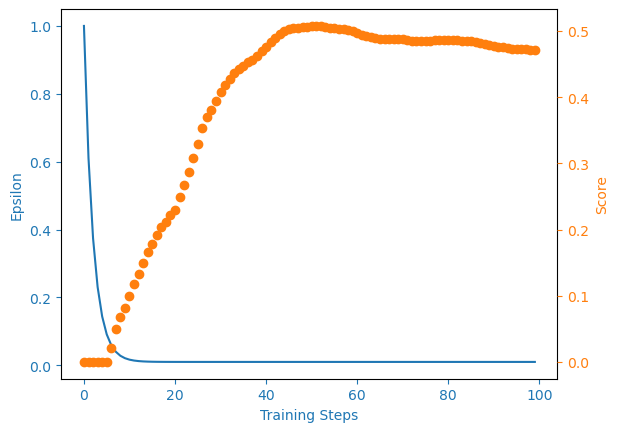

In [21]:
import gymnasium as gym
import numpy as np 
import pickle

FROZENLAKE_ENV = gym.make("FrozenLake-v1", render_mode="rgb_array")
NOA_SPACE = FROZENLAKE_ENV.action_space.n
NOS_SPACE = FROZENLAKE_ENV.observation_space.n 
NOE = 10000
MAX_EPSILON = 1
ALPHA = 0.83
GAMMA = 0.94
MIN_EPSILON = 0.01
DECAY_RATE = 0.0001
MAX_STEP = 10000
EPSILON = 1

if __name__ == "__main__": 
  
    q_table, training_rewards, epsilon_history, avg_rewards = train_model(FROZENLAKE_ENV,
                        NOS_SPACE,
                        NOA_SPACE,
                        noe=NOE,
			            epsilon=EPSILON,
                        max_epsilon=MAX_EPSILON,
                        alpha=ALPHA,
                        gamma=GAMMA,
                        min_epsilon=MIN_EPSILON,
                        max_steps = MAX_STEP
                    )
    with open("frozenlake_q_table.obj", "wb") as f: 
        pickle.dump(q_table, f) 
        print("Completed the traning of the model!!")

    plot_learning_curve(avg_rewards, epsilon_history, "q_learning_frozenlake")   


In [25]:
import random 
import imageio
import tensorflow as tf 
import pickle

class Eval: 

    def __init__(self, env, qtable_obj_path, video_prefix, number_of_episode=50):
        self.env = env 
        self.recorder = RecordVideo(video_prefix, 'test_videos/', 15)
        self.number_of_episode = number_of_episode
        self.Qtable = pickle.load(open(qtable_obj_path, "rb"))
        
    def test(self): 
        rewards = []
        steps = []
        for episode in range(self.number_of_episode): 
            done = False
            reward = 0
            step = 0
            state = env.reset(seed=random.randint(0,500))
            if episode % 10 == 0: 
                img = env.render()
                self.recorder.add_image(img) 

            while not done:
                if type(state) == tuple:
                    state = state[0]
                action = np.argmax(self.Qtable[state][:])
                state, reward_prob, terminated, truncated, _ = env.step(action)
                done = terminated or truncated 
                reward += reward_prob
                step += 1 
                if episode % 10 == 0:
                    img = env.render()
                    self.recorder.add_image(img)
            
            rewards.append(reward)
            steps.append(step)
            self.recorder.save(episode) if episode % 10 == 0 else None
        
        return rewards, steps


env = gym.make("FrozenLake-v1", render_mode="rgb_array")
evaluator = Eval(env, "/kaggle/input/frozenlake-object/frozenlake_q_table.obj",
                                 "qlearning", 50)

rewards, steps = evaluator.test()